In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import os
# import numpy as np
# import matplotlib
# import datetime

In [2]:
# Settings for displaying floats
pd.set_option('display.float_format', '{:,.2f}'.format)

In [3]:
df = pd.read_csv("./data/cleaned_data.csv")
df.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,Wind-speed,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2014,12,29,AT,Graz,47.07,15.45,"269,997.00",0.10,9.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,12,29,AT,Innsbruck,47.26,11.39,"124,579.00",0.10,25.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,12,29,AT,Linz,48.31,14.29,"193,814.00",0.10,14.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,12,29,AT,Salzburg,47.80,13.04,"146,631.00",0.10,21.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,12,29,AT,Vienna,48.21,16.37,NaN,0.10,9.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.columns

# Some redundant columns still need to be rempved from df manually: Temperature, Pressure, Wind-speed

Index(['Year', 'Month', 'Day', 'Country', 'City', 'Latitude', 'Longitude',
       'Population', 'Co', 'No2', 'O3', 'Pm10', 'Pm25', 'Pressure', 'So2',
       'Temperature', 'Wind-gust', 'Wind-speed', 'Dew', 'Humidity', 'Tavg',
       'Tmin', 'Tmax', 'Prcp', 'Wdir', 'Wspd', 'Pres'],
      dtype='object')

In [5]:
# Drop redundant columns

df = df.drop(columns=['Temperature', 'Wind-speed', 'Pressure'])
df.columns

Index(['Year', 'Month', 'Day', 'Country', 'City', 'Latitude', 'Longitude',
       'Population', 'Co', 'No2', 'O3', 'Pm10', 'Pm25', 'So2', 'Wind-gust',
       'Dew', 'Humidity', 'Tavg', 'Tmin', 'Tmax', 'Prcp', 'Wdir', 'Wspd',
       'Pres'],
      dtype='object')

In [8]:
# Function to create overview for dtypes, missing values, unique values

def overview(df):
    '''
    Erstelle einen Überblick über einige Eigenschaften der Spalten eines DataFrames.
    VARs
        df: Der zu betrachtende DataFrame
    RETURNS:
        None
    '''
    display(pd.DataFrame({'dtype': df.dtypes,
                          'total': df.count(),
                          'missing': df.isna().sum(),
                          'missing%': df.isna().mean()*100,
                          'n_uniques': df.nunique(),
                          'uniques%': df.nunique()/df.shape[0]*100,
                          'uniques': [df[col].unique() for col in df.columns]
                         }))


In [9]:
overview(df)

,dtype,total,missing,missing%,n_uniques,uniques%,uniques
Year,int64,1695041,0,0.00,12,0.00,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202..."
Month,int64,1695041,0,0.00,12,0.00,"[12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]"
Day,int64,1695041,0,0.00,31,0.00,"[29, 30, 31, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11..."
Country,object,1695041,0,0.00,95,0.01,"[AT, AU, BE, BO, BR, CA, CH, CL, CN, CO, CY, C..."
City,object,1695041,0,0.00,616,0.04,"[Graz, Innsbruck, Linz, Salzburg, Vienna, Bris..."
Latitude,float64,1692212,2829,0.17,617,0.04,"[47.06667, 47.26266, 48.30639, 47.79941, 48.20..."
Longitude,float64,1692212,2829,0.17,616,0.04,"[15.45, 11.39454, 14.28611, 13.04399, 16.37208..."
Population,float64,363474,1331567,78.56,1289,0.08,"[269997.0, 124579.0, 193814.0, 146631.0, nan, ..."
Co,float64,1063231,631810,37.27,1009,0.06,"[0.1, 1.9, 2.1, nan, 2.3, 2.0, 3.4, 5.5, 3.8, ..."
No2,float64,1408781,286260,16.89,1291,0.08,"[9.0, 25.6, 14.2, 21.1, 4.6, 0.7, nan, 6.5, 4...."


In [11]:
# Focus on missing values: Sort missing values (descending)

missing_percent = df.isna().mean() * 100
missing_percent_sorted = missing_values.sort_values(ascending=False)

print(missing_percent_sorted)


Population   78.56
Wind-gust    54.21
Dew          40.99
Prcp         38.73
Co           37.27
So2          31.44
Wdir         31.00
Pres         29.03
Wspd         26.90
Humidity     22.90
O3           22.07
Pm10         20.17
Tmax         18.93
Tmin         18.79
Tavg         17.35
No2          16.89
Pm25         15.50
Longitude     0.17
Latitude      0.17
Month         0.00
City          0.00
Country       0.00
Day           0.00
Year          0.00
dtype: float64


In [12]:
# Remove all columns with more than 50% missing values
# Note: This removes population data entirely!

df = df.loc[:, missing_percent <= 50]

# Print what has changed
print(f"Anzahl der entfernten Spalten: {df.shape[1] - df.shape[1]}")
print("Übrige Spalten:", df.columns)

df.head()

Anzahl der entfernten Spalten: 0
Übrige Spalten: Index(['Year', 'Month', 'Day', 'Country', 'City', 'Latitude', 'Longitude',
       'Co', 'No2', 'O3', 'Pm10', 'Pm25', 'So2', 'Dew', 'Humidity', 'Tavg',
       'Tmin', 'Tmax', 'Prcp', 'Wdir', 'Wspd', 'Pres'],
      dtype='object')


,Year,Month,Day,Country,City,Latitude,Longitude,Co,No2,O3,...,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2014,12,29,AT,Graz,47.07,15.45,0.10,9.00,NaN,...,1.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,12,29,AT,Innsbruck,47.26,11.39,0.10,25.60,NaN,...,1.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,12,29,AT,Linz,48.31,14.29,0.10,14.20,NaN,...,2.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,12,29,AT,Salzburg,47.80,13.04,0.10,21.10,NaN,...,2.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,12,29,AT,Vienna,48.21,16.37,0.10,9.00,NaN,...,2.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df.shape

(1695041, 22)

In [14]:
df.describe()

,Year,Month,Day,Latitude,Longitude,Co,No2,O3,Pm10,Pm25,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
count,"1,695,041.00","1,695,041.00","1,695,041.00","1,692,212.00","1,692,212.00","1,063,231.00","1,408,781.00","1,320,893.00","1,353,189.00","1,432,252.00","1,162,066.00","1,000,165.00","1,306,961.00","1,400,959.00","1,376,504.00","1,374,164.00","1,038,543.00","1,169,606.00","1,239,023.00","1,202,982.00"
mean,"2,020.31",5.83,15.72,31.82,26.66,4.77,9.76,20.46,27.07,53.25,3.98,9.69,68.66,15.38,10.82,20.38,2.98,183.52,11.34,"1,015.15"
std,2.64,3.37,8.85,23.60,77.93,8.89,10.50,15.39,27.69,41.04,8.82,9.59,23.91,9.54,9.38,10.21,8.99,106.93,6.24,8.12
min,"2,014.00",1.00,1.00,-45.87,-157.86,0.00,0.00,0.00,0.00,0.00,0.00,-64.30,"-2,671.10",-41.00,-46.00,-37.20,0.00,0.00,0.00,925.20
25%,"2,019.00",3.00,8.00,26.84,-3.70,1.40,4.60,11.80,12.00,25.00,1.20,3.00,58.30,8.70,4.30,13.10,0.00,86.00,7.00,"1,010.00"
50%,"2,020.00",5.00,16.00,38.04,20.15,3.40,7.50,19.90,19.00,42.00,2.50,10.00,72.80,15.90,11.00,21.10,0.00,194.00,10.00,"1,015.00"
75%,"2,022.00",9.00,23.00,46.81,102.24,5.60,12.40,27.20,34.00,67.00,4.30,16.60,83.00,22.70,17.70,28.30,1.70,274.00,14.20,"1,020.30"
max,"2,025.00",12.00,31.00,65.01,175.28,500.00,500.00,500.00,999.00,999.00,500.00,32.00,999.90,44.80,39.00,87.00,462.00,360.00,176.30,"1,392.10"


In [15]:
df.sample(20)

,Year,Month,Day,Country,City,Latitude,Longitude,Co,No2,O3,...,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
1327586,2023,2,25,RO,Cluj-napoca,46.77,23.60,NaN,21.70,NaN,...,3.10,3.50,88.70,5.10,2.50,11.70,1.40,264.00,6.10,"1,002.10"
1595617,2024,9,13,FR,Tours,47.39,0.70,NaN,3.30,19.80,...,NaN,7.00,73.50,7.80,6.40,13.70,0.30,342.00,8.10,"1,026.30"
381375,2018,6,20,TH,Bangkok,13.75,100.50,0.10,5.80,6.10,...,0.80,NaN,0.00,30.30,28.20,NaN,0.00,NaN,NaN,NaN
988055,2021,6,30,JP,Shizuoka,34.98,138.38,1.20,6.50,33.60,...,1.50,19.90,83.20,22.60,21.00,25.10,0.00,48.00,11.80,"1,011.40"
770614,2020,8,21,CA,Edmonton,53.55,-113.47,1.20,3.80,0.10,...,2.60,13.00,76.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1618080,2024,10,22,ES,Las palmas de gran canaria,28.10,-15.41,0.10,4.60,27.30,...,3.10,17.70,67.90,23.20,22.20,26.50,0.00,9.00,33.30,"1,020.40"
634129,2020,2,1,IN,New delhi,28.64,77.22,NaN,NaN,NaN,...,NaN,9.00,73.50,12.30,5.70,19.70,NaN,NaN,3.20,"1,018.70"
1255142,2022,10,24,MY,Johor bahru,1.47,103.76,NaN,NaN,NaN,...,NaN,24.00,83.00,27.20,26.00,30.00,14.10,340.00,6.50,"1,010.20"
1385459,2023,6,5,HR,Split,43.51,16.44,NaN,NaN,NaN,...,1.60,16.50,79.50,19.70,17.00,22.00,41.90,91.00,14.00,"1,015.90"
1094812,2021,11,24,NP,Pokhara,28.27,83.97,NaN,NaN,NaN,...,NaN,14.60,85.90,15.50,10.30,21.30,NaN,151.00,4.10,"1,017.60"


In [ ]:
# # Heatmap of missing values by city (NOT useful for big df; can be used with selection of up to 100 cities)

# missing_by_city = df.groupby('City').apply(lambda x: x.isnull().sum())
# missing_by_city_percent = missing_by_city / len(df) * 100  # Prozentsatz der fehlenden Werte

# missing_by_city_percent

# plt.figure(figsize=(12, 30))
# sns.heatmap(missing_by_city, cmap="Reds", annot=True, fmt=".0f", linewidths=0.5)
# plt.title("Fehlende Werte pro Stadt und Messwert")
# plt.xlabel("Messwerte")
# plt.ylabel("Stadt")
# plt.xticks(rotation=90)
# plt.show()


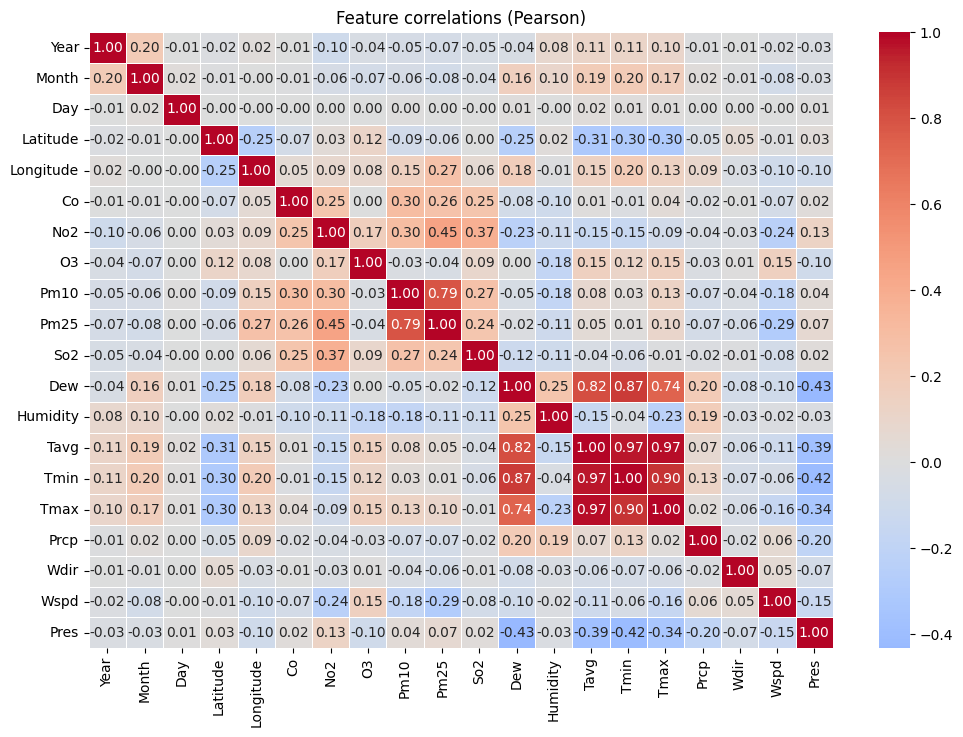

In [16]:
# Collinearity of features? (heatmap)

# > 0.8 = strong correlation
# 0.5 - 0.8 = moderate correlation
# < 0.5 = weal correlation

# calculate correlation matrix (Pearson)
corr_matrix = df.select_dtypes(include=['number']).corr()

# Display heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Feature correlations (Pearson)");


In [18]:
# Show only strong and moderate correaltions (>|0.5|); leave out main diagonal (1.0)

# Calculte matrix
corr_matrix = df.select_dtypes(include=['number']).corr()

# extract only strong and moderate correlations (>|0.5|); leave out main diagonal (1.0)
strong_corrs = corr_matrix[(corr_matrix.abs() > 0.4) & (corr_matrix.abs() < 1.0)]

# Convert df to long list (.stack) and reset index
strong_corrs = strong_corrs.stack().reset_index()
strong_corrs.columns = ["Feature 1", "Feature 2", "Korrelation"]

# remove redundant rows (note: the "<"-sign here refers to alphabetic order of feature names, not to numbers of any kind!)
strong_corrs = strong_corrs.loc[strong_corrs["Feature 1"] < strong_corrs["Feature 2"]]

strong_corrs

,Feature 1,Feature 2,Korrelation
0,No2,Pm25,0.45
1,Pm10,Pm25,0.79
4,Dew,Tavg,0.82
5,Dew,Tmin,0.87
6,Dew,Tmax,0.74
7,Dew,Pres,-0.43
9,Tavg,Tmin,0.97
10,Tavg,Tmax,0.97
17,Tmax,Tmin,0.90
19,Pres,Tmin,-0.42


In [19]:
# Results: On a global scale, there are only expected correlations

# Weather features:
# The three temperature features (Tavg, Tmin, Tmax) are naturally almost identical
# Temperature and Dew are highly correlated - which is to be expected as the dew point is immediately dependent on temperature
# Weak negative correlation between latitude and temperature: Cities further north of the equator are typically colder.
# Moderate negative correlation between dew point and pressure: Low pressure --> high dew point, i.e. more moisture in the air during low-pressure weather. However, other factors like altutude and local weather should be considered before drawing conclusions.

# Air pollutants
# Moderate correlation (0.45) between nitrogen dioxide and medium-sized fine dust particles. Possible reasons: Both are side products of industrial combustion processes. Also, NO2 can react with ammonia or sulfur dioxide to produce secondary fine dust particles (salts like ammonium nitrate or ammonium sulphate)

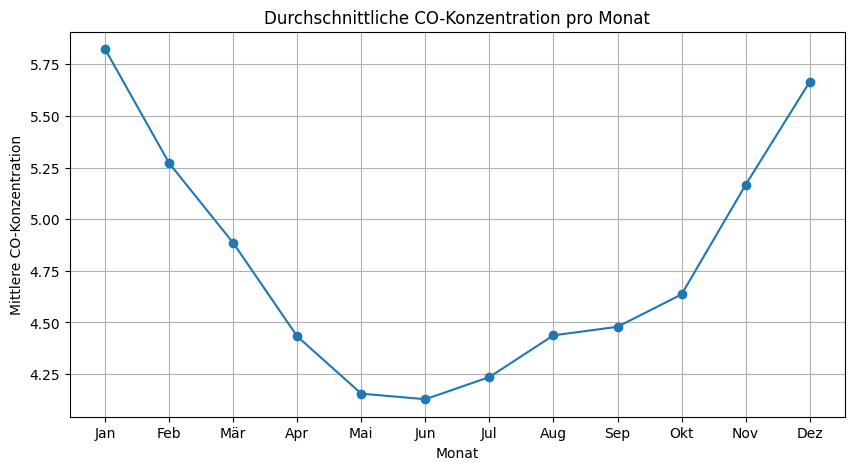

In [30]:
# Plot changes throughout the year. Example: Analyse CO concentration per month

# calculate mean CO per month
monthly_co = df.groupby("Month")["Co"].mean()
# monthly_co = df.groupby("Month")["Co"].mean()

# create plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_co.index, monthly_co.values, marker='o', linestyle='-')
plt.xlabel("Monat")
plt.ylabel("Mittlere CO-Konzentration")
plt.title("Durchschnittliche CO-Konzentration pro Monat")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.grid(True);

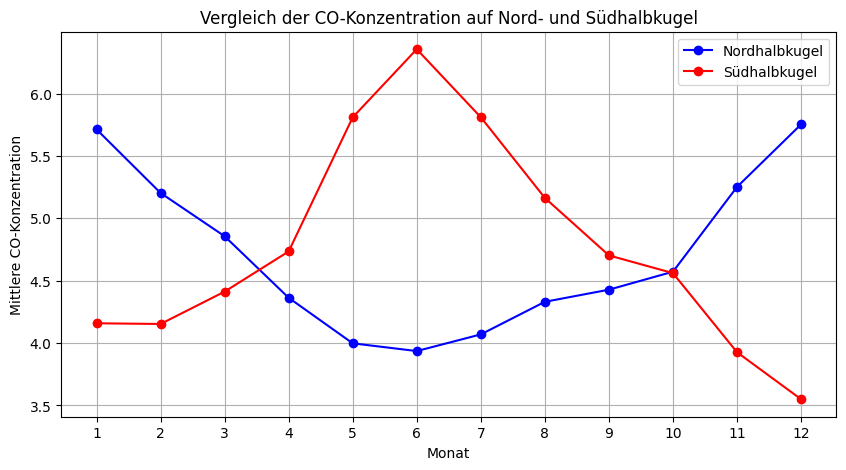

In [34]:
# Trennung der Daten in Nord- und Südhalbkugel

# Definieren, welche Länder zur Nord- und Südhalbkugel gehören
northern_hemisphere_countries = {
    "US", "CA", "MX", "DE", "FR", "GB", "RU", "CN", "JP", "IN", "IT", "ES", "PL", "TR", "IR", "KR", "UA", "NL", "BE",
    "CH", "SE", "AT", "NO", "FI", "DK", "GR", "CZ", "HU", "RO", "BG", "PT", "IE", "SK", "HR", "LT", "SI", "LV", "EE"
}
southern_hemisphere_countries = {
    "AU", "NZ", "AR", "BR", "ZA", "CL", "ID", "PE", "BO", "EC", "PY", "UY", "MG"
}

# Daten für Nord- und Südhalbkugel filtern
df_north = df[df["Country"].isin(northern_hemisphere_countries)]
df_south = df[df["Country"].isin(southern_hemisphere_countries)]

# Mittlere CO-Konzentration pro Monat berechnen
monthly_co_north = df_north.groupby("Month")["Co"].mean()
monthly_co_south = df_south.groupby("Month")["Co"].mean()

# Plot erstellen
plt.figure(figsize=(10, 5))
plt.plot(monthly_co_north.index, monthly_co_north.values, marker='o', linestyle='-', label="Nordhalbkugel", color='b')
plt.plot(monthly_co_south.index, monthly_co_south.values, marker='o', linestyle='-', label="Südhalbkugel", color='r')

plt.xlabel("Monat")
plt.ylabel("Mittlere CO-Konzentration")
plt.title("Vergleich der CO-Konzentration auf Nord- und Südhalbkugel")
plt.xticks(range(1, 13))  # Monatsskala 1-12
plt.legend()
plt.grid(True);

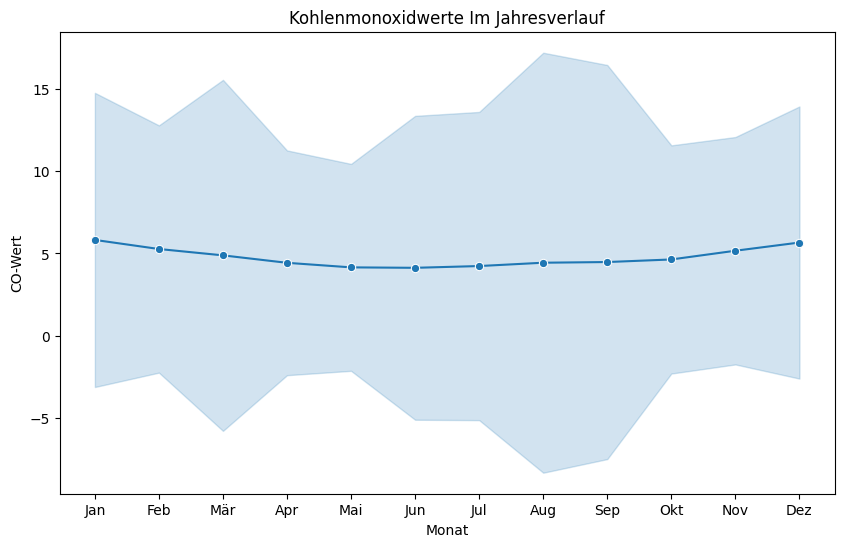

In [ ]:
# CO-Werte über das Jahr inklusive Streuung

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Month", y="Co", errorbar="sd", marker="o")
plt.xlabel("Monat")
plt.ylabel("CO-Wert")
plt.title("Kohlenmonoxidwerte Im Jahresverlauf")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.show()

# Die Grafik ist nicht intuitiv aussagekräftig. Die Streuung ist zu stark.

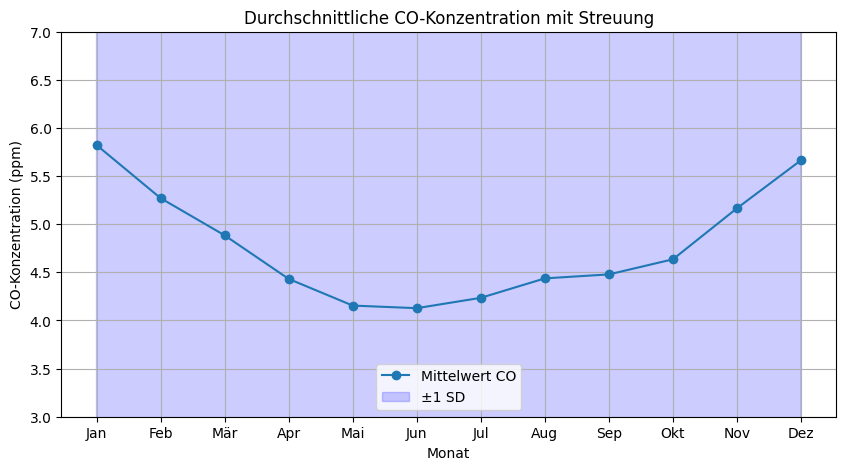

In [ ]:
# Streuung mit Achsenbegrenzung

# Gruppiere nach Monat
grouped = df.groupby("Month")["Co"]
mean = grouped.mean()
std = grouped.std()

# Plot erstellen
plt.figure(figsize=(10, 5))
plt.plot(mean.index, mean.values, marker='o', linestyle='-', label='Mittelwert CO')
plt.fill_between(mean.index, mean - std, mean + std, color='blue', alpha=0.2, label='±1 SD')

# Achsen, Titel, Beschriftungen
plt.xlabel("Monat")
plt.ylabel("CO-Konzentration (ppm)")
plt.title("Durchschnittliche CO-Konzentration mit Streuung")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])

# Fokus auf relevanten y-Bereich
plt.ylim(3, 7)  # oder anpassen je nach Datensatz

plt.grid(True)
plt.legend()
plt.show()

# Ergebnis: Die Streuung bedeckt die gesamte Diagrammfläche. Es sollten als die Städte, die die größte Verzerrung bewirken, aussortiert werden.


In [ ]:
co_by_city = df.groupby("City")["Co"].mean().sort_values(ascending=False)
print(co_by_city.head(10))

# Ashkelon ist ein unrealistischer Ausreißer. Siehe separates NB "Ashkelon": Es gibt nur Messwerte für Jan und Feb 2022, und diese schwanken extrem. Vielleicht kaputtes Messgerät.

City
Ashkelon       138.73
Ashdod          58.76
Netanya         34.05
Tabriz          33.97
Zarqa           32.34
Butuan          29.35
Bandar abbas    27.33
Karaj           26.81
Shiraz          26.60
Orūmīyeh        26.25
Name: Co, dtype: float64


In [36]:
# calculate std per city

co_std_by_city = df.groupby("City")["Co"].std().sort_values(ascending=False)
print(co_std_by_city.head(10))

City
Ashdod      101.27
Netanya      87.64
Portland     87.21
Mérida       71.69
Ashkelon     69.61
Zamboanga    36.40
Butuan       29.00
Hạ long      26.42
Oaxaca       25.12
Isfahan      22.85
Name: Co, dtype: float64


In [37]:
# combine mean and std to determine cities that cause the bigges distortions.

co_stats = df.groupby("City")["Co"].agg(["mean", "std"]).sort_values(by="mean", ascending=False)
print(co_stats.head(10))

               mean    std
City                      
Ashkelon     138.73  69.61
Ashdod        58.76 101.27
Netanya       34.05  87.64
Tabriz        33.97  22.21
Zarqa         32.34  14.02
Butuan        29.35  29.00
Bandar abbas  27.33  15.17
Karaj         26.81  15.21
Shiraz        26.60  12.63
Orūmīyeh      26.25  21.36


In [ ]:
# The three Israeli cities of Ashkelon, Ashdod and Netanya show highly volatile CO values, measured only in certain months.
# This distorts the graph to an extent that calls for dropping these three cities from further analyes of CO.

In [38]:
# Drop distorting cities from fürther analyses
exclude_cities = ["Ashkelon", "Ashdod", "Netanya"]
df_cleaned = df[~df["City"].isin(exclude_cities)]

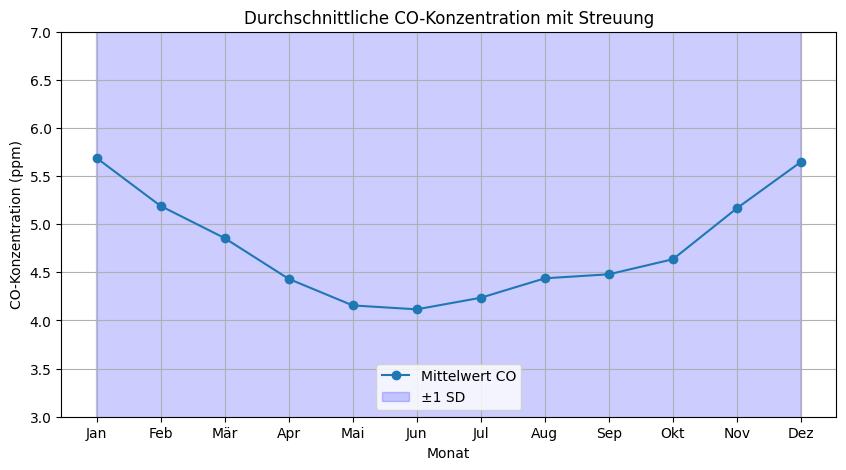

In [39]:
# Streuung mit Achsenbegrenzung, ohne Ausreißerstädte in Israel

# Gruppiere nach Monat
grouped = df_cleaned.groupby("Month")["Co"]
mean = grouped.mean()
std = grouped.std()

# Plot erstellen
plt.figure(figsize=(10, 5))
plt.plot(mean.index, mean.values, marker='o', linestyle='-', label='Mittelwert CO')
plt.fill_between(mean.index, mean - std, mean + std, color='blue', alpha=0.2, label='±1 SD')

# Achsen, Titel, Beschriftungen
plt.xlabel("Monat")
plt.ylabel("CO-Konzentration (ppm)")
plt.title("Durchschnittliche CO-Konzentration mit Streuung")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])

# Fokus auf relevanten y-Bereich
plt.ylim(3, 7)  # oder anpassen je nach Datensatz

plt.grid(True)
plt.legend()
plt.show()

# Ergebnis: Die Streuung bedeckt die gesamte Diagrammfläche. Es sollten als die Städte, die die größte Verzerrung bewirken, aussortiert werden.


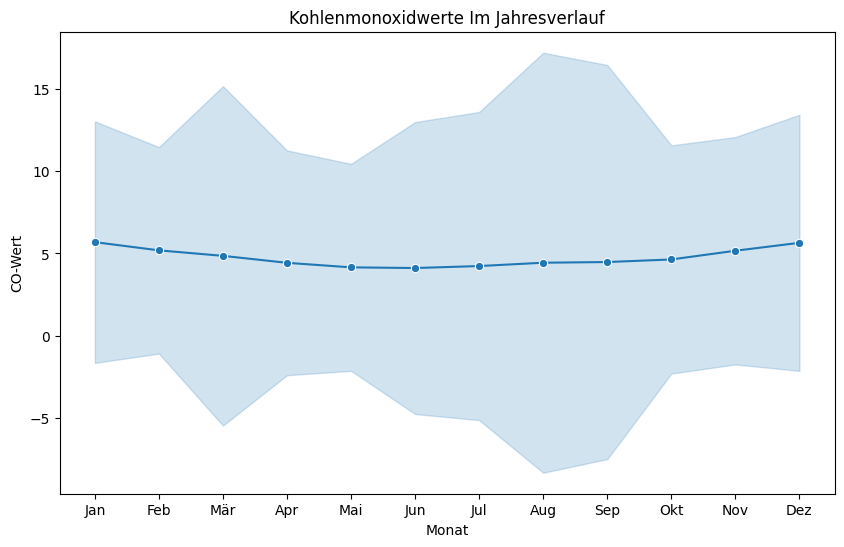

In [ ]:
# CO-Werte über das Jahr inklusive Streuung

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_cleaned, x="Month", y="Co", errorbar="sd", marker="o")
plt.xlabel("Monat")
plt.ylabel("CO-Wert")
plt.title("Kohlenmonoxidwerte Im Jahresverlauf")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.show()

# Die Grafik ist immer noch nicht nicht intuitiv aussagekräftig. Die Streuung ist weiterhin zu stark.

In [41]:
# Ursachenforschung für die starke CO-Streuung

co_std_cleaned = df_cleaned.groupby("City")["Co"].std().sort_values(ascending=False)
print(co_std_cleaned.head(10))

City
Portland          87.21
Mérida            71.69
Zamboanga         36.40
Butuan            29.00
Hạ long           26.42
Oaxaca            25.12
Isfahan           22.85
San luis potosí   22.84
Tabriz            22.21
Tallahassee       21.92
Name: Co, dtype: float64


In [42]:
co_stats_cleaned = df_cleaned.groupby("City")["Co"].agg(["mean", "std"]).sort_values(by="std", ascending=False)
print(co_stats_cleaned.head(10))

                 mean   std
City                       
Portland        17.82 87.21
Mérida          26.01 71.69
Zamboanga        6.54 36.40
Butuan          29.35 29.00
Hạ long         12.74 26.42
Oaxaca          16.21 25.12
Isfahan         23.21 22.85
San luis potosí  8.00 22.84
Tabriz          33.97 22.21
Tallahassee      2.74 21.92


In [43]:
# Weitere Städte mit extremer Varianz entfernen, um eine übersichtliche globale Darstellung zu erzielen

more_extreme = ["Portland", "Mérida", "Zamboanga", "Butuan", "Hạ long", "Oaxaca", "Isfahan", "San luis potosí", "Tabriz", "Tallahassee"]
exclude_cities = ["Ashkelon", "Ashdod", "Netanya"] + more_extreme
df_cleaned2 = df[~df["City"].isin(exclude_cities)]

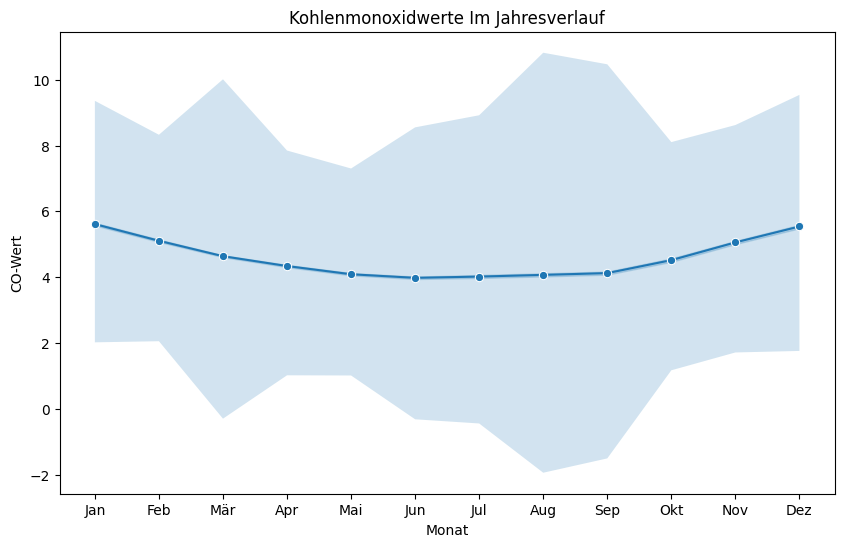

In [47]:
# CO-Werte über das Jahr inklusive Streuung, weiter reduziert

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_cleaned2, x="Month", y="Co", marker="o")
plt.fill_between(mean.index, mean - std * 0.5, mean + std * 0.5, alpha=0.2, label='±0.5 SD')
plt.xlabel("Monat")
plt.ylabel("CO-Wert")
plt.title("Kohlenmonoxidwerte Im Jahresverlauf")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.show()

# Die Grafik ist immer noch nicht nicht intuitiv aussagekräftig. Die Streuung ist weiterhin zu stark.

In [54]:

# Nord- und Südhalbkugel anhand des Features "Latitude" trennen

df_cleaned2.loc[:, "Hemisphere"] = df_cleaned2.loc[:, "Latitude"].apply(lambda x: "Nordhalbkugel" if x >= 0 else "Südhalbkugel")



In [55]:
df_north = df_cleaned2[df_cleaned2["Hemisphere"] == "Nordhalbkugel"]
df_south = df_cleaned2[df_cleaned2["Hemisphere"] == "Südhalbkugel"]

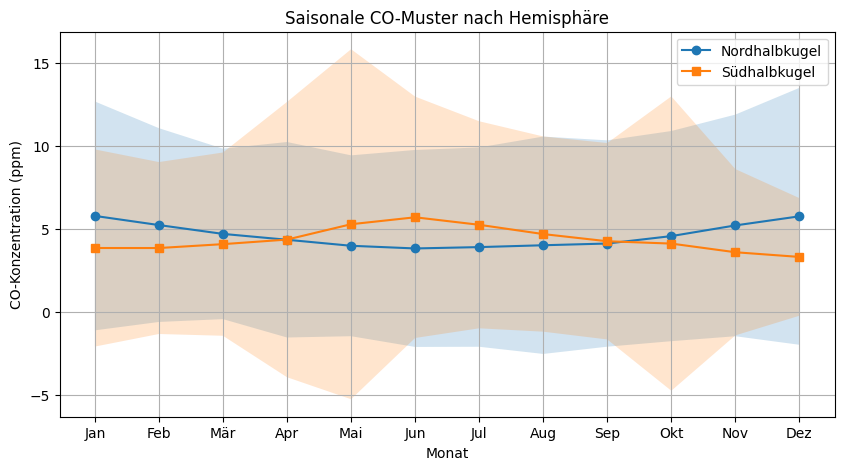

In [63]:
# Nordhalbkugel
grouped_north = df_north.groupby("Month")["Co"]
mean_north = grouped_north.mean()
std_north = grouped_north.std()

# Südhalbkugel
grouped_south = df_south.groupby("Month")["Co"]
mean_south = grouped_south.mean()
std_south = grouped_south.std()

# Plot
plt.figure(figsize=(10, 5))

plt.plot(mean_north.index, mean_north, marker='o', label="Nordhalbkugel")
plt.fill_between(mean_north.index, mean_north - std_north, mean_north + std_north, alpha=0.2)

plt.plot(mean_south.index, mean_south, marker='s', label="Südhalbkugel")
plt.fill_between(mean_south.index, mean_south - std_south, mean_south + std_south, alpha=0.2)

plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.xlabel("Monat")
plt.ylabel("CO-Konzentration (ppm)")
plt.title("Saisonale CO-Muster nach Hemisphäre")
plt.legend()
plt.grid(True)
plt.show()


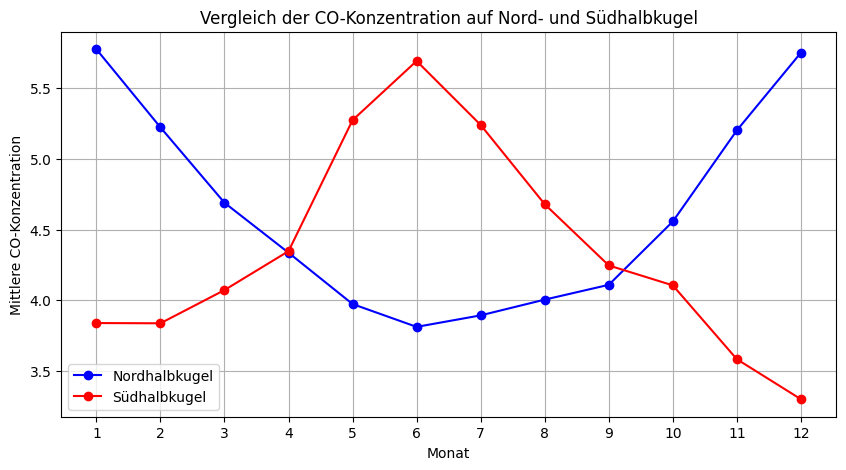

In [ ]:
# Mittlere CO-Konzentration pro Monat berechnen
monthly_co_north = df_north.groupby("Month")["Co"].mean()
monthly_co_south = df_south.groupby("Month")["Co"].mean()

# Plot erstellen
plt.figure(figsize=(10, 5))
plt.plot(monthly_co_north.index, monthly_co_north.values, marker='o', linestyle='-', label="Nordhalbkugel", color='b')
plt.plot(monthly_co_south.index, monthly_co_south.values, marker='o', linestyle='-', label="Südhalbkugel", color='r')

plt.xlabel("Monat")
plt.ylabel("Mittlere CO-Konzentration")
plt.title("Vergleich der CO-Konzentration auf Nord- und Südhalbkugel")
plt.xticks(range(1, 13))  # Monatsskala 1-12
plt.legend()
plt.grid(True);

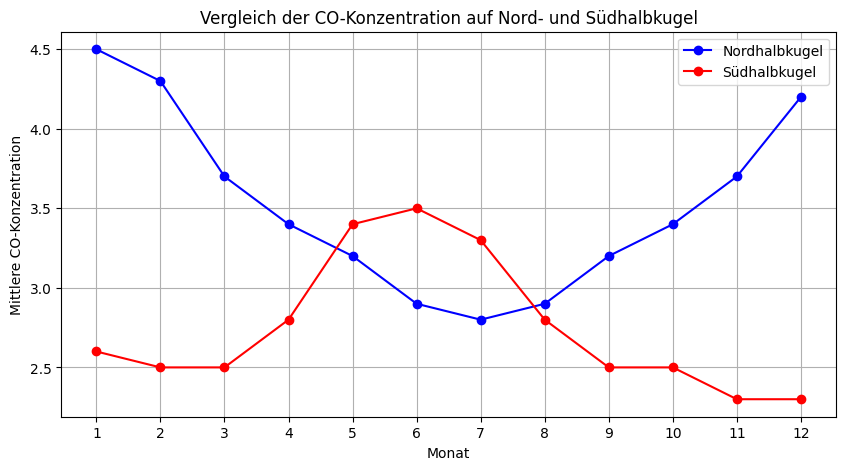

In [61]:
# Mittlere CO-Konzentration pro Monat berechnen- Median statt Mean, weil robuster gegen Ausreißer
monthly_co_north = df_north.groupby("Month")["Co"].median()
monthly_co_south = df_south.groupby("Month")["Co"].median()

# Plot erstellen
plt.figure(figsize=(10, 5))
plt.plot(monthly_co_north.index, monthly_co_north.values, marker='o', linestyle='-', label="Nordhalbkugel", color='b')
plt.plot(monthly_co_south.index, monthly_co_south.values, marker='o', linestyle='-', label="Südhalbkugel", color='r')

plt.xlabel("Monat")
plt.ylabel("Mittlere CO-Konzentration")
plt.title("Vergleich der CO-Konzentration auf Nord- und Südhalbkugel")
plt.xticks(range(1, 13))  # Monatsskala 1-12
plt.legend()
plt.grid(True);

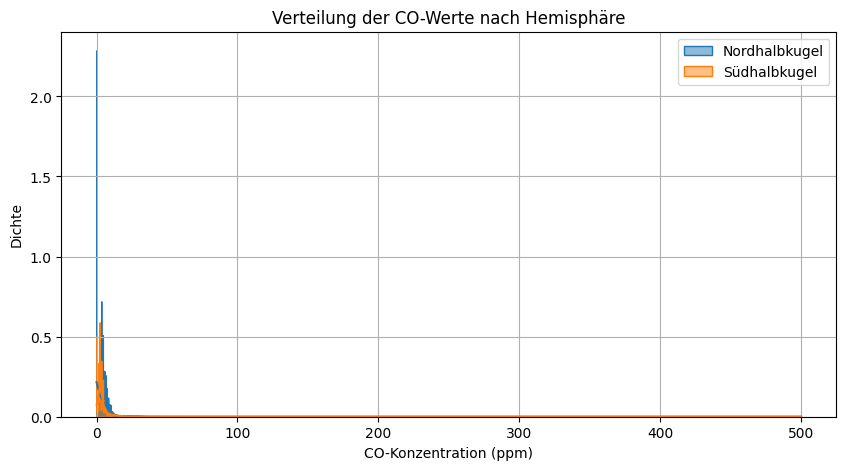

In [65]:
# sns.histplot(df_north["Co"], kde=True)
# sns.histplot(df_south["Co"], kde=True)

plt.figure(figsize=(10, 5))

# Nordhalbkugel
sns.histplot(df_north["Co"], kde=True, label="Nordhalbkugel", stat="density", element="step", fill=True)

# Südhalbkugel
sns.histplot(df_south["Co"], kde=True, label="Südhalbkugel", stat="density", element="step", fill=True)

# Achsen & Legende
plt.xlabel("CO-Konzentration (ppm)")
plt.ylabel("Dichte")
plt.title("Verteilung der CO-Werte nach Hemisphäre")
plt.legend()
plt.grid(True)
plt.show()


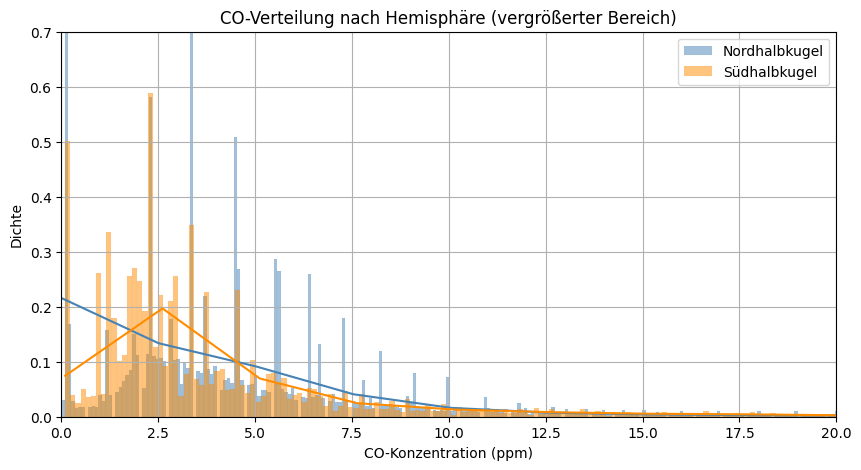

In [66]:
plt.figure(figsize=(10, 5))

# Histogramm Nordhalbkugel
sns.histplot(df_north["Co"], kde=True, stat="density", label="Nordhalbkugel", color="steelblue", fill=True)

# Histogramm Südhalbkugel
sns.histplot(df_south["Co"], kde=True, stat="density", label="Südhalbkugel", color="darkorange", fill=True)

# Zoom auf interessanten Bereich
plt.xlim(0, 20)    # X-Achse (CO-Werte) begrenzen
plt.ylim(0, 0.7)   # Y-Achse (Dichte) begrenzen

# Titel & Achsen
plt.xlabel("CO-Konzentration (ppm)")
plt.ylabel("Dichte")
plt.title("CO-Verteilung nach Hemisphäre (vergrößerter Bereich)")
plt.legend()
plt.grid(True)
plt.show()


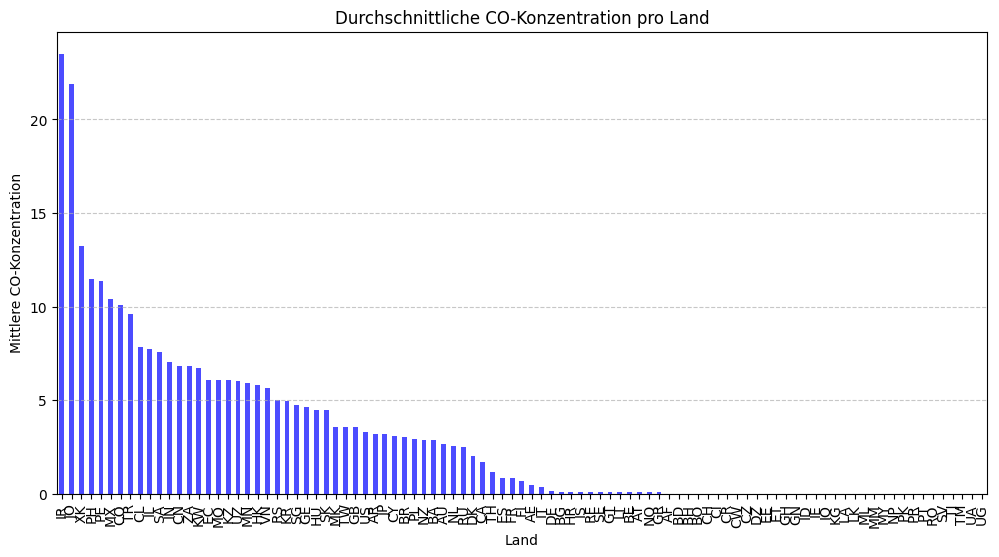

In [24]:
# Mittlere CO-Konzentration pro Land berechnen
country_co_avg = df.groupby("Country")["Co"].mean().sort_values(ascending=False)

# Barplot erstellen
plt.figure(figsize=(12, 6))
country_co_avg.plot(kind='bar', color='b', alpha=0.7)
plt.xlabel("Land")
plt.ylabel("Mittlere CO-Konzentration")
plt.title("Durchschnittliche CO-Konzentration pro Land")
plt.xticks(rotation=90)  # Länderbeschriftung drehen für bessere Lesbarkeit
plt.grid(axis='y', linestyle='--', alpha=0.7);


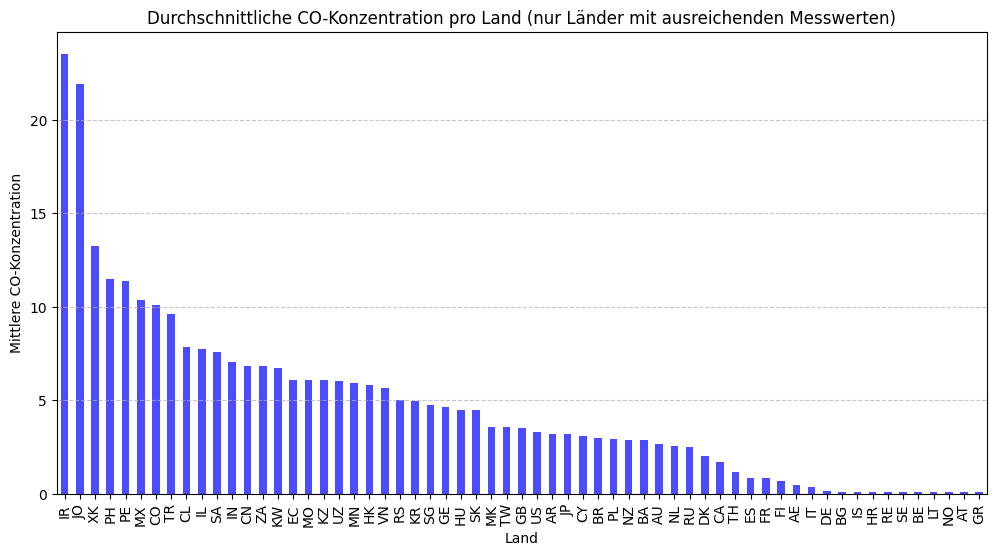

In [25]:
# Mittlere CO-Konzentration pro Land berechnen

# Mindestanzahl an CO-Messwerten pro Land, um in die Analyse aufgenommen zu werden
min_measurements = 100  # Falls nötig, anpassen

# Anzahl der CO-Messwerte pro Land berechnen
country_co_counts = df.groupby("Country")["Co"].count()

# Nur Länder behalten, die mindestens `min_measurements` Messwerte haben
valid_countries = country_co_counts[country_co_counts >= min_measurements].index

# Gefilterten DataFrame mit diesen Ländern erstellen
df_valid_countries = df[df["Country"].isin(valid_countries)]

# Mittlere CO-Konzentration für diese Länder berechnen
country_co_avg_filtered = df_valid_countries.groupby("Country")["Co"].mean().sort_values(ascending=False)

# Falls nach der Filterung noch Daten vorhanden sind, Plot erstellen
if not country_co_avg_filtered.empty:
    plt.figure(figsize=(12, 6))
    country_co_avg_filtered.plot(kind='bar', color='b', alpha=0.7)
    plt.xlabel("Land")
    plt.ylabel("Mittlere CO-Konzentration")
    plt.title("Durchschnittliche CO-Konzentration pro Land (nur Länder mit ausreichenden Messwerten)")
    plt.xticks(rotation=90)  # Länderbeschriftung drehen für bessere Lesbarkeit
    plt.grid(axis='y', linestyle='--', alpha=0.7)
else:
    print("Keine ausreichenden Daten für CO-Werte in den Ländern verfügbar.")


<Axes: xlabel='Country'>

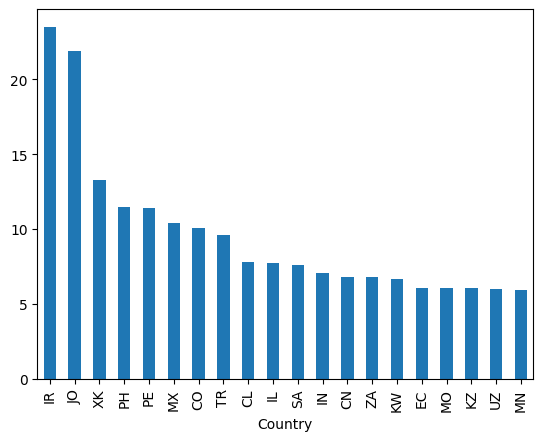

In [26]:
country_co_avg_filtered.head(20).plot(kind='bar')


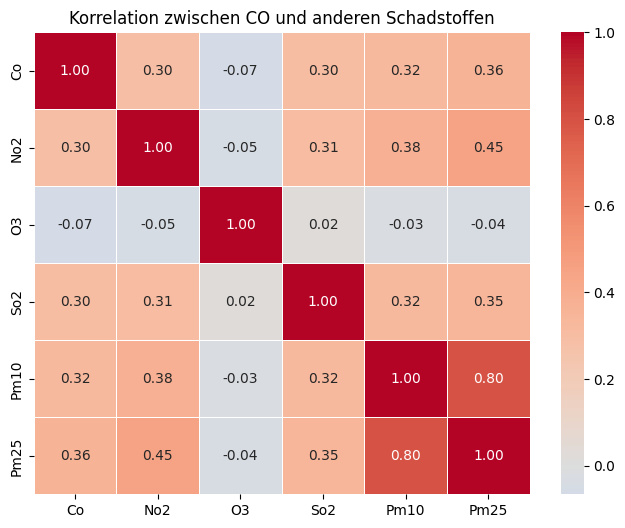

In [28]:
# Vergleich von Schadstoffen in verschiedenen Städten

# Liste der relevanten Schadstoff-Spalten (falls sie in den Daten vorhanden sind)
pollutants = ["Co", "No2", "O3", "So2", "Pm10", "Pm25"]

# DataFrame mit nur den relevanten Spalten (fehlende Werte entfernen)
df_pollutants = df[pollutants].dropna()

# Korrelationsmatrix berechnen
corr_matrix = df_pollutants.corr()

# Heatmap der Korrelationen erstellen
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Korrelation zwischen CO und anderen Schadstoffen");


In [29]:
df[["Co", "No2"]].corr()

,Co,No2
Co,1.00,0.25
No2,0.25,1.00


In [ ]:
# Korrelation Schadstoffe und Wettervariablen

# Liste der Schadstoffe und Wettervariablen
pollutants = ["Co", "No2", "O3", "So2", "Pm10", "Pm25"]
weather_vars = ["temperature", "pressure", "humidity", "dew", "wind-speed", "wind-gust"]

# DataFrame mit nur den relevanten Spalten (fehlende Werte entfernen)
df_pollutants_weather = df[pollutants + weather_vars].dropna()

# Korrelationsmatrix berechnen
corr_matrix_weather = df_pollutants_weather.corr()

# Heatmap der Korrelationen zwischen Schadstoffen & Wettervariablen
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_weather, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Korrelation zwischen Schadstoffen und Wetterfaktoren");

In [ ]:
df[["co", "temperature"]].corr()

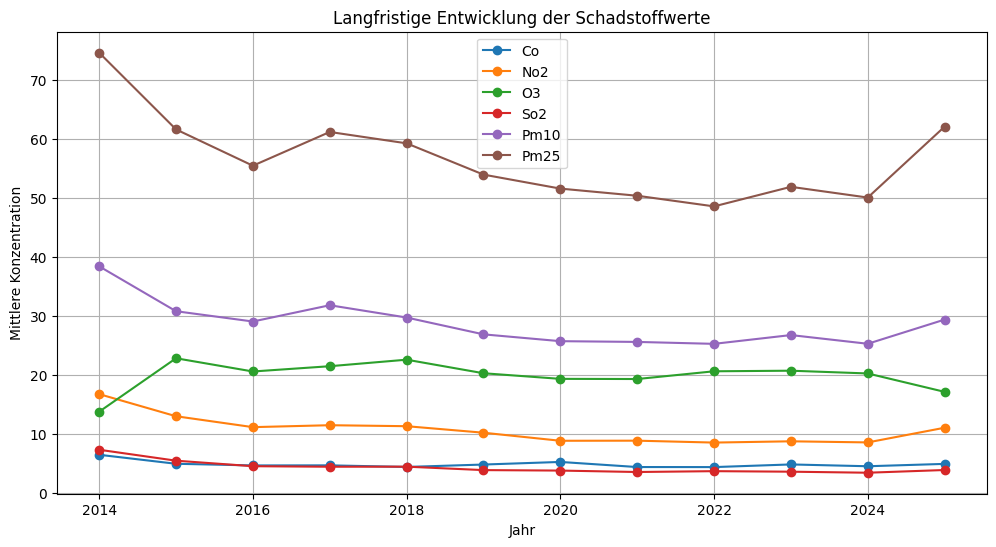

In [31]:
# Schadstoffbelastung über die Zeit in verschiedenen Städten

# Durchschnittliche Schadstoffwerte pro Jahr berechnen
pollutants = ["Co", "No2", "O3", "So2", "Pm10", "Pm25"]
yearly_trends = df.groupby("Year")[pollutants].mean()

# Liniendiagramm für langfristige Trends erstellen
plt.figure(figsize=(12, 6))
for pollutant in pollutants:
    plt.plot(yearly_trends.index, yearly_trends[pollutant], marker='o', linestyle='-', label=pollutant)

plt.xlabel("Jahr")
plt.ylabel("Mittlere Konzentration")
plt.title("Langfristige Entwicklung der Schadstoffwerte")
plt.legend()
plt.grid(True);


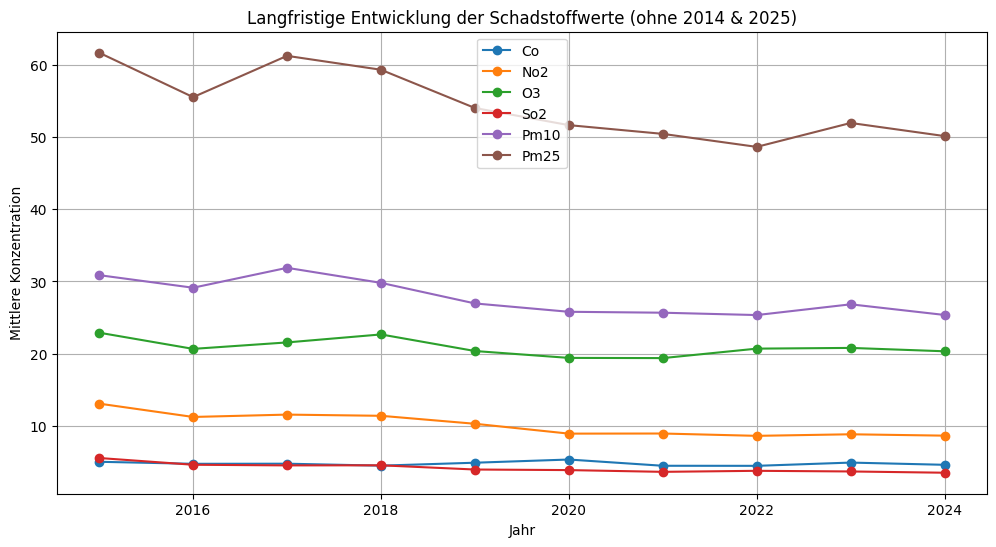

In [33]:
# Ohne 2014 und 2025, weil zu wenige Daten

# Schadstoffe, die analysiert werden sollen
pollutants = ["Co", "No2", "O3", "So2", "Pm10", "Pm25"]

# Falls "year" als String gespeichert ist, in numerischen Wert umwandeln
df["year"] = pd.to_numeric(df["Year"], errors="coerce")

# Durchschnittliche Schadstoffwerte pro Jahr berechnen, aber 2014 & 2025 ausschließen
yearly_trends = df.groupby("Year")[pollutants].mean()
yearly_trends = yearly_trends.loc[(yearly_trends.index > 2014) & (yearly_trends.index < 2025)]

# Liniendiagramm für langfristige Trends erstellen
plt.figure(figsize=(12, 6))
for pollutant in pollutants:
    plt.plot(yearly_trends.index, yearly_trends[pollutant], marker='o', linestyle='-', label=pollutant)

plt.xlabel("Jahr")
plt.ylabel("Mittlere Konzentration")
plt.title("Langfristige Entwicklung der Schadstoffwerte (ohne 2014 & 2025)")
plt.legend()
plt.grid(True);


In [39]:
num_cities_with_data = df.loc[:, ["City", "Co", "No2", "So2", "O3", "Pm25", "Pm10"]].dropna(subset=["Co", "No2", "So2", "O3", "Pm25", "Pm10"], how="all")["City"].nunique()
print(f"Anzahl der Städte mit mindestens einem Messwert: {num_cities_with_data}")

Anzahl der Städte mit mindestens einem Messwert: 603


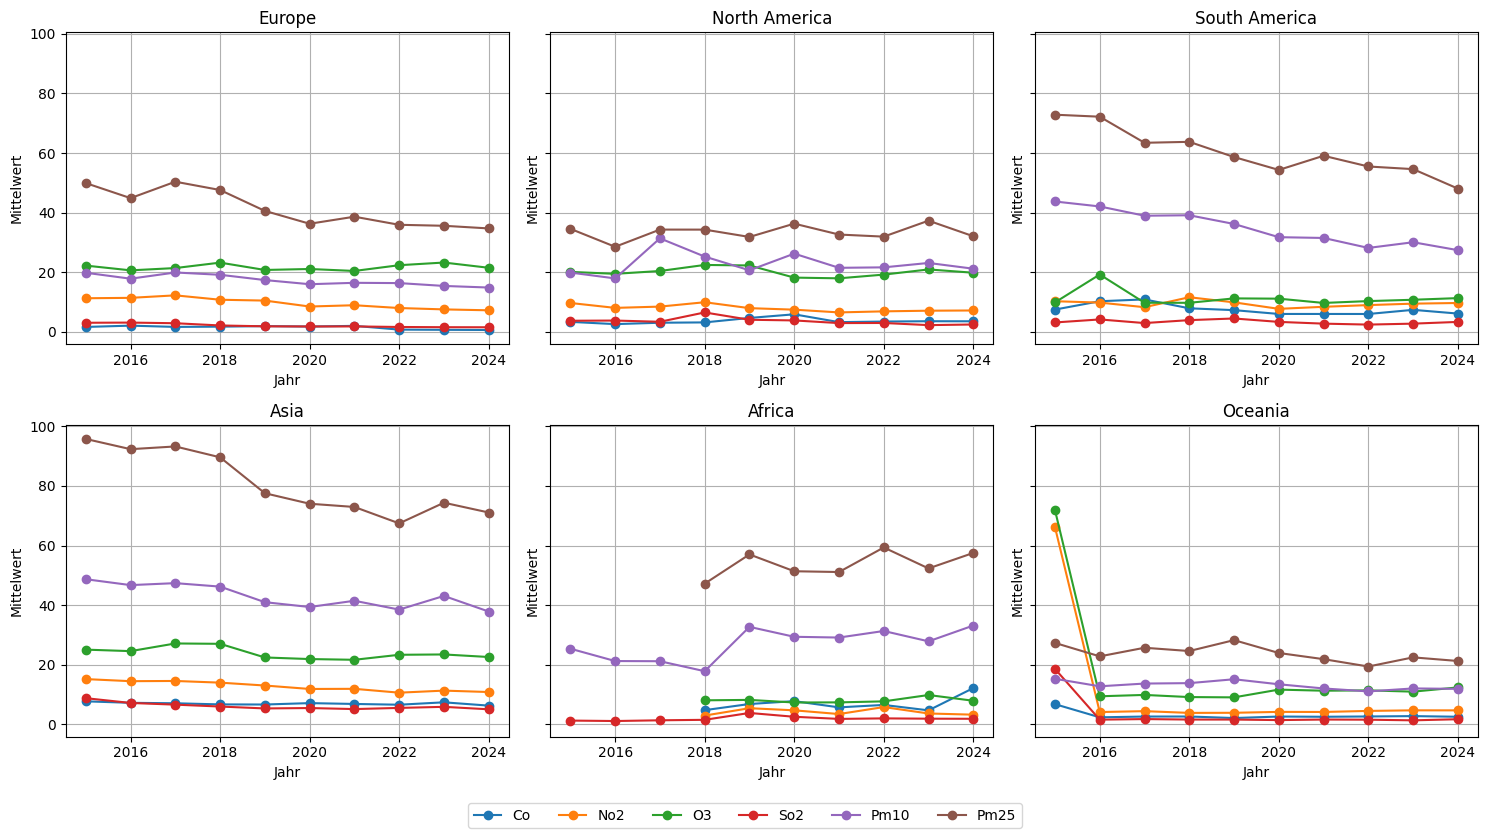

In [34]:
    import matplotlib.pyplot as plt

    # Schadstoffe, die analysiert werden sollen
    pollutants = ["Co", "No2", "O3", "So2", "Pm10", "Pm25"]

    # Länder nach Regionen gruppieren
    regions = {
        "Europe": {"DE", "FR", "GB", "IT", "ES", "PL", "NL", "SE", "AT", "CH", "BE"},
        "North America": {"US", "CA", "MX"},
        "South America": {"BR", "AR", "CO", "CL", "PE"},
        "Asia": {"CN", "IN", "JP", "KR", "IR"},
        "Africa": {"ZA", "EG", "NG"},
        "Oceania": {"AU", "NZ"}
    }

    # Falls "year" als String gespeichert ist, in numerischen Wert umwandeln
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

    # Regionen durchgehen & Diagramme erstellen
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)  # Einheitliche Achsen für bessere Vergleichbarkeit
    axes = axes.flatten()  # 2D-Array in 1D-Array umwandeln

    # Speichert alle Linien für die gemeinsame Legende
    handles, labels = [], []

    for i, (region, countries) in enumerate(regions.items()):
        df_region = df[df["Country"].isin(countries)]
        yearly_trends_region = df_region.groupby("Year")[pollutants].mean()
        yearly_trends_region = yearly_trends_region.loc[(yearly_trends_region.index > 2014) & (yearly_trends_region.index < 2025)]
        
        ax = axes[i]
        for pollutant in pollutants:
            line, = ax.plot(yearly_trends_region.index, yearly_trends_region[pollutant], marker='o', linestyle='-', label=pollutant)
            
            # Speichert eine Linie pro Schadstoff für die gemeinsame Legende
            if i == 0:  
                handles.append(line)
                labels.append(pollutant)

        ax.set_title(region)
        ax.set_xlabel("Jahr")
        ax.set_ylabel("Mittelwert")
        ax.grid(True)

    for ax in axes[:3]:  # Die ersten drei Subplots sind in der oberen Reihe
        ax.xaxis.set_tick_params(labelbottom=True)

    # Gemeinsame Legende unterhalb der Subplots platzieren
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(pollutants))

    # Layout optimieren
    plt.tight_layout();

In [32]:
# Sechs Top-Länder in Europa

import matplotlib.pyplot as plt

# Schadstoffe, die analysiert werden sollen
pollutants = ["co", "no2", "o3", "so2", "pm10", "pm25"]

# Europäische Länder definieren
european_countries = {"DE", "FR", "GB", "IT", "ES", "PL", "NL", "SE", "AT", "CH", "BE"}

# Falls "year" als String gespeichert ist, in numerischen Wert umwandeln
df["year"] = pd.to_numeric(df["year"], errors="coerce")

# Nur europäische Länder auswählen
df_europe = df[df["Country"].isin(european_countries)]

# Länder mit den meisten Messwerten identifizieren
top_countries = df_europe["Country"].value_counts().nlargest(6).index  # Falls nur 6 Länder visualisiert werden sollen

# Subplots für die gewählten Länder erstellen
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)  # 2 Reihen, 3 Spalten
axes = axes.flatten()

for i, country in enumerate(top_countries):
    df_country = df_europe[df_europe["Country"] == country]
    yearly_trends_country = df_country.groupby("year")[pollutants].mean()
    yearly_trends_country = yearly_trends_country.loc[(yearly_trends_country.index > 2014) & (yearly_trends_country.index < 2025)]
    
    ax = axes[i]
    for pollutant in pollutants:
        ax.plot(yearly_trends_country.index, yearly_trends_country[pollutant], marker='o', linestyle='-', label=pollutant)
    
    ax.set_title(country)
    ax.set_xlabel("Jahr")
    ax.set_ylabel("Mittelwert")
    ax.grid(True)

# Gemeinsame Legende unterhalb der Subplots platzieren
fig.legend(pollutants, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(pollutants))

# Layout optimieren
plt.tight_layout();

KeyError: 'year'

In [ ]:
# Korrekation zwischen Ozon und anderen Faktoren

# Relevante Spalten auswählen
pollutants = ["co", "no2", "so2", "pm10", "pm25", "o3"]
weather_vars = ["temperature", "pressure", "humidity", "dew", "wind-speed", "wind-gust"]

# DataFrame mit nur den relevanten Spalten (fehlende Werte entfernen)
df_ozone_corr = df[pollutants + weather_vars].dropna()

# Korrelationsmatrix berechnen
corr_matrix_ozone = df_ozone_corr.corr()

# Heatmap der Korrelationen zwischen Ozon und anderen Faktoren
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_ozone, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Korrelation zwischen Ozon (O₃) und anderen Faktoren");


In [ ]:
# Durchschnittliche Ozonwerte pro Monat berechnen
monthly_o3 = df.groupby("month")["o3"].mean()

# Liniendiagramm für die saisonale Entwicklung von Ozon erstellen
plt.figure(figsize=(10, 5))
plt.plot(monthly_o3.index, monthly_o3.values, marker='o', linestyle='-', color='b')
plt.xlabel("Monat")
plt.ylabel("Mittlere O₃-Konzentration")
plt.title("Saisonale Entwicklung der Ozonwerte (O₃)")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.grid(True);

In [ ]:
# Länder nach Hemisphäre aufteilen
northern_hemisphere_countries = {
    "US", "CA", "MX", "DE", "FR", "GB", "IT", "ES", "PL", "NL", "SE", "AT", "CH", "BE", "RU", "CN", "JP", "IN", "KR"
}
southern_hemisphere_countries = {
    "AU", "NZ", "AR", "BR", "ZA", "CL", "ID", "PE", "BO", "EC", "PY", "UY", "MG"
}

# Daten für Nord- und Südhalbkugel filtern
df_north = df[df["Country"].isin(northern_hemisphere_countries)]
df_south = df[df["Country"].isin(southern_hemisphere_countries)]

# Durchschnittliche Ozonwerte pro Monat für beide Hemisphären berechnen
monthly_o3_north = df_north.groupby("month")["o3"].mean()
monthly_o3_south = df_south.groupby("month")["o3"].mean()

# Plot erstellen
plt.figure(figsize=(10, 5))
plt.plot(monthly_o3_north.index, monthly_o3_north.values, marker='o', linestyle='-', label="Nordhalbkugel", color='b')
plt.plot(monthly_o3_south.index, monthly_o3_south.values, marker='o', linestyle='-', label="Südhalbkugel", color='r')

plt.xlabel("Monat")
plt.ylabel("Mittlere O₃-Konzentration")
plt.title("Vergleich der Ozonwerte (O₃) zwischen Nord- und Südhalbkugel")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"])
plt.legend()
plt.grid(True);



In [ ]:
import matplotlib.pyplot as plt

# Europäische Länder definieren
european_countries = {"DE", "FR", "GB", "IT", "ES", "PL", "NL", "SE", "AT", "CH", "BE"}

# Falls "year" als String gespeichert ist, in numerischen Wert umwandeln
df["year"] = pd.to_numeric(df["year"], errors="coerce")

# Nur europäische Länder auswählen
df_europe = df[df["Country"].isin(european_countries)]

# Jahre 2014 & 2025 aus der Analyse entfernen
df_europe = df_europe[(df_europe["year"] > 2014) & (df_europe["year"] < 2025)]

# Nur Länder behalten, die tatsächlich O₃-Werte haben
countries_with_o3 = df_europe.groupby("Country")["o3"].count()
valid_countries = countries_with_o3[countries_with_o3 > 0].index  # Länder mit vorhandenen O₃-Werten

# DataFrame auf diese Länder filtern
df_europe = df_europe[df_europe["Country"].isin(valid_countries)]

# Standardabweichung (Schwankungsstärke) von O₃ pro Jahr & Land berechnen
ozone_volatility = df_europe.groupby(["year", "Country"])["o3"].std().unstack()

# Diagramm erstellen
fig, ax = plt.subplots(figsize=(12, 6))
handles = []  # Zum Speichern der Linien für die Legende
labels = []   # Zum Speichern der Ländernamen

for country in ozone_volatility.columns:
    line, = ax.plot(ozone_volatility.index, ozone_volatility[country], marker='o', linestyle='-', label=country)
    handles.append(line)
    labels.append(country)

ax.set_xlabel("Jahr")
ax.set_ylabel("Standardabweichung von O₃ (Schwankungsstärke)")
ax.set_title("Jährliche Schwankungsstärke der Ozonwerte in europäischen Ländern (nur Länder mit Daten)")
ax.grid(True)

# Legende unterhalb des Plots platzieren
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=len(valid_countries))

# Layout optimieren
plt.tight_layout();

In [ ]:
# Clusteranalyse zur Schadstoffbelastung

from sklearn.preprocessing import StandardScaler

# Liste der Schadstoff-Features für das Clustering
pollutants = ["co", "no2", "o3", "so2", "pm10", "pm25"]

# Durchschnittliche Schadstoffwerte pro Land berechnen
df_cluster = df.groupby("Country")[pollutants].mean().dropna()

# Daten skalieren (K-Means ist empfindlich gegenüber unterschiedlichen Skalen)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# Ergebnis als DataFrame zurückgeben
df_cluster_scaled = pd.DataFrame(df_scaled, index=df_cluster.index, columns=pollutants)

# Überprüfen, ob die Daten korrekt vorbereitet sind
df_cluster_scaled.head()


In [ ]:
from sklearn.cluster import KMeans

# Teste verschiedene Clusterzahlen (k = 1 bis 10)
inertia = []
k_values = range(1, 31)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_cluster_scaled)
    inertia.append(kmeans.inertia_)  # Speichert den Fehler (Inertia)

# Elbow-Plot erstellen
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.xlabel("Anzahl der Cluster (k)")
plt.ylabel("Inertia (Fehler)")
plt.title("Elbow-Methode zur Bestimmung der optimalen Clusterzahl")
plt.grid(True);


In [ ]:
from sklearn.metrics import silhouette_score

# Teste verschiedene Clusterzahlen (k = 2 bis 10, weil k=1 keine Silhouettenwertung hat)
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_cluster_scaled)
    score = silhouette_score(df_cluster_scaled, labels)
    silhouette_scores.append(score)

# Silhouetten-Plot erstellen
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-')
plt.xlabel("Anzahl der Cluster (k)")
plt.ylabel("Silhouetten-Koeffizient")
plt.title("Silhouetten-Analyse zur Bestimmung der optimalen Clusterzahl")
plt.grid(True);


Entscheidung: 5 Cluster nehmen

In [ ]:
# K-Means Clustering mit k=5
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_cluster_scaled["Cluster"] = kmeans.fit_predict(df_cluster_scaled)

# Cluster-Zugehörigkeit pro Land anzeigen
df_clusters = df_cluster_scaled[["Cluster"]]
df_clusters.head()


In [ ]:
df_clusters["Cluster"].value_counts()


In [ ]:
df_cluster_scaled.groupby("Cluster").mean()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x=df_cluster_scaled["Cluster"], y=df_cluster_scaled["pm25"])
plt.xlabel("Cluster")
plt.ylabel("PM2.5-Werte (standardisiert)")
plt.title("Vergleich der PM2.5-Werte in den Clustern")
plt.grid(True);

In [ ]:
# Länder und ihre Cluster-Zugehörigkeit anzeigen
df_clusters_sorted = df_clusters.sort_values(by="Cluster")  # Nach Cluster sortieren
df_clusters_sorted


In [ ]:
# Test mit 4 oder 6 Clustern

# K-Means mit 4 und 6 Clustern testen
for k in [4, 6]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    df_cluster_scaled[f"Cluster_{k}"] = kmeans.fit_predict(df_cluster_scaled)

# Ergebnisse anzeigen
df_clusters_test = df_cluster_scaled[["Cluster_4", "Cluster_6"]]
df_clusters_test


In [ ]:
df_cluster_scaled.groupby("Cluster").mean()


In [ ]:
# K-Means nochmal ausführen, mit Stadt statt Land

from sklearn.preprocessing import StandardScaler

# Liste der Schadstoff-Features für das Clustering
pollutants = ["co", "no2", "o3", "so2", "pm10", "pm25"]

# Durchschnittliche Schadstoffwerte pro Stadt berechnen
df_cluster = df.groupby("City")[pollutants].mean().dropna()

# Daten skalieren (K-Means ist empfindlich gegenüber unterschiedlichen Skalen)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# Ergebnis als DataFrame zurückgeben
df_cluster_scaled = pd.DataFrame(df_scaled, index=df_cluster.index, columns=pollutants)

# Überprüfen, ob die Daten korrekt vorbereitet sind
df_cluster_scaled.head()


In [ ]:

# Teheran rausschmeißen


from sklearn.cluster import KMeans

# Teste verschiedene Clusterzahlen (k = 1 bis 30) ohne Teheran
inertia_no_tehran = []
k_values = range(1, 31)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_cluster_no_tehran.drop(columns=["Cluster"]))  # Clustering ohne vorherige Cluster-Spalte
    inertia_no_tehran.append(kmeans.inertia_)

# Elbow-Plot erstellen
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_no_tehran, marker='o', linestyle='-')
plt.xlabel("Anzahl der Cluster (k)")
plt.ylabel("Inertia (Fehler)")
plt.title("Elbow-Methode ohne Teheran")
plt.grid(True);



In [ ]:
# K-Means Clustering mit 4 Clustern (oder einer anderen optimalen Zahl)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_cluster_scaled["Cluster"] = kmeans.fit_predict(df_cluster_scaled)

# Cluster-Zugehörigkeit pro Stadt anzeigen
df_clusters = df_cluster_scaled[["Cluster"]]
df_clusters_sorted = df_clusters.sort_values(by="Cluster")  # Sortiert nach Cluster
df_clusters_sorted


In [ ]:
# Teheran aus dem DataFrame entfernen
df_cluster_no_tehran = df_cluster_scaled.drop(index="Tehran")

# K-Means erneut ausführen mit 5 Clustern (oder einer anderen optimalen Zahl)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_cluster_no_tehran["Cluster"] = kmeans.fit_predict(df_cluster_no_tehran)

# Neue Cluster-Zugehörigkeit der Städte anzeigen
df_clusters_no_tehran = df_cluster_no_tehran[["Cluster"]]
df_clusters_no_tehran_sorted = df_clusters_no_tehran.sort_values(by="Cluster")  # Sortiert nach Cluster
df_clusters_no_tehran_sorted
